# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import MultiheadAttention
#from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 64
num_workers = 4

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
transform_valid_test = transforms.Compose([transforms.Resize((299, 299)), 
                                           transforms.ToTensor()])

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data2',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers, persistent_workers=True, drop_last=True)

test_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=False,
                               transform=transform_valid_test)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)
    

Files already downloaded and verified
Files already downloaded and verified


# Ny block: Trækker 5000 CIFAR10 billeder til at beregne training FID

In [3]:
train_FID_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=True,
                               transform=transform_valid_test)

train_for_FID, _ = random_split(train_FID_dataset, [5000, 45000])

train_for_FID_loader = torch.utils.data.DataLoader(train_for_FID, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified


In [3]:
# COSINE SCHEDULE

def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return (torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2)).clamp(max=0.99999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([(f(t)/f(torch.tensor([0]))).clamp(max=0.99999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

In [4]:
# Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
# LINEAR SCHEDULE
T = 1000
beta_start, beta_end = [1e-4, 2e-02]
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1-beta
alpha_bar = alpha.clone()
for e in range(T-1):
    alpha_bar[e+1] *= alpha_bar[e]

alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

## Model

In [5]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [64, 128, 256]
        #mha = MultiheadAttention(128, 64)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(4, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.GroupNorm(num_groups=8, num_channels=channels[0]),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.GroupNorm(num_groups=8, num_channels=channels[1]),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.ReLU(),
            )
        ])

        self.midconvs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels[-1], channels[0], kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[0]),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[-1]+channels[0], channels[1], kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[1]),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]+channels[1], channels[2], kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[2]),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[2]+channels[1], channels[2]*2, kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[2]*2),
                nn.ReLU()
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[2]*2, channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1]*2, channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]*2,channels[0],kernel_size=3,padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
                nn.Conv2d(channels[0],3,kernel_size=1) # (batchsize, 1, 28, 28)
            )            
        ])
    
    def forward(self, x, t):
        #print(x.shape)
        #print(t.shape)
        x_trans = torch.cat((x, t), dim=-3)

        signal = x_trans

        signals = []

        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            #print(signal.shape)
            signal = conv(signal)
            # print(signal.shape)
            if i < len(self.convs)-1:
                signals.append(signal)
        #for s in signals:
            #print(s.shape)
        #print(signal.shape)
        mid_conv_signals = [signal]
        #signal = self.midconvs(signal)
        for i, conv in enumerate(self.midconvs):
            # print(f"conv {i}")
            #print(signal.shape)
            if i == 0:
                #print(signal.shape)
                signal = conv(signal)
            else:
                #print(signal.shape, signals[-i].shape)
                signal = torch.cat((signal, mid_conv_signals[i-1]), dim=-3)
                signal = conv(signal)
            mid_conv_signals.append(signal)
        
        for i, tconv in enumerate(self.tconvs):
            #print(signal.shape)
            #print(i)
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                #print(signal.shape)
                signal = tconv(signal)
            #elif i == 2:
            #    signal = torch.cat((signal, signals[-i]), dim=-3)
                #print(signal.shape)
           #     signal = tconv(signal)
            else:
                #print(signal.shape, signals[-i].shape)
                signal = torch.cat((signal, signals[-i]), dim=-3)
                #print(signal.shape)
                signal = tconv(signal)
        return signal

## Training loop

In [7]:
#from UNET import UNET
epochs = 500
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
running_loss = 0
batch_size = 64

In [8]:
model = UNET()
model.to(device)
model.load_state_dict(torch.load("DDPM_final_bottleneck_2_86.pth"))
model.train()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#criterion = torch.nn.MSELoss(reduction="sum")
#running_loss = 0
#batch_size = 16

UNET(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GroupNorm(8, 128, eps=1e-05, affine=True)
      (3): ReLU()
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
  )
  (midconvs): ModuleList(
    (0): Sequential(
      (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(320, 128, kernel_size=(3, 3), stride=(1, 1)

# Træner og gemmer model 1, 100, 200, 300, 400, 500, 800, 1100, 1400 og 1707. Gemmer losses i losses.txt. Kan evt. ændres til at gemme færre modeller hvis det tager lang tid

In [9]:
for epoch in range(86, epochs+1):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        #print(t.shape)
        eps = torch.randn(batch_size, 3, 32, 32).to(device)
        # print(eps.shape)
        # print(x0.shape)
        loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                    torch.sqrt(1 - alpha_bar[t-1]) * eps, (t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)-1) / 1000))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if e % 100 == 99:
            print(f'{epoch, e+1}, loss: {running_loss:.3f}')
            with open("losses_bottleneck_2.txt", "a") as file:
                file.write(f"{running_loss:.3f}\n")
            
            running_loss = 0.0
        
    if epoch in [1, 100, 200, 300, 400, 500, 600, 700, 800, 1100, 1400]:
        torch.save(model.state_dict(), f"DDPM_final_bottleneck_2_{epoch}.pth")
torch.save(model.state_dict(), f"DDPM_final_bottleneck_2_{epoch}.pth")

(86, 100), loss: 667330.329
(86, 200), loss: 664741.935
(86, 300), loss: 664186.788
(86, 400), loss: 669046.685
(86, 500), loss: 666045.773
(86, 600), loss: 647441.704
(86, 700), loss: 645690.443
(87, 100), loss: 1183310.872
(87, 200), loss: 674451.421
(87, 300), loss: 659006.297
(87, 400), loss: 673229.788
(87, 500), loss: 623862.598
(87, 600), loss: 634990.639
(87, 700), loss: 670996.066
(88, 100), loss: 1218750.025
(88, 200), loss: 664755.094
(88, 300), loss: 672517.692
(88, 400), loss: 684161.252
(88, 500), loss: 662209.131
(88, 600), loss: 676209.102
(88, 700), loss: 665989.551
(89, 100), loss: 1221524.874
(89, 200), loss: 649524.764
(89, 300), loss: 670978.456
(89, 400), loss: 678249.675
(89, 500), loss: 662238.943
(89, 600), loss: 665699.965
(89, 700), loss: 678391.760
(90, 100), loss: 1197850.390
(90, 200), loss: 685082.159
(90, 300), loss: 645322.129
(90, 400), loss: 661674.541
(90, 500), loss: 666169.350
(90, 600), loss: 670614.698
(90, 700), loss: 649356.844
(91, 100), loss:

In [8]:
torch.save(model.state_dict(), f"DDPM_final_bottleneck_2_{epoch}.pth")

In [9]:
epoch

86

# Sampling

In [20]:
import matplotlib.pyplot as plt
model.eval()

UNET(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GroupNorm(8, 128, eps=1e-05, affine=True)
      (3): ReLU()
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GroupNorm(8, 256, eps=1e-05, affine=True)
      (3): ReLU()
    )
  )
  (midconvs): ModuleList(
    (0): Sequential(
      (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0

In [52]:
#model = UNET()
#model.to(device)
#model.load_state_dict(torch.load("DDPM_final_linear_300.pth"))

<All keys matched successfully>

In [22]:
model.eval()
batch_size = 1
xt = torch.randn(batch_size, 3, 32, 32).to(device)
for t in torch.arange(T, 0, -1):
    #print(t)
    t = t.to(device)
    z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
    xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                   model(xt, (t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)-1)/1000)) + torch.sqrt(beta[t-1]) * z
    xt = xt_new
    #if t == 1:
        #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
im = xt[0].permute(1, 2, 0)
im = im.cpu().detach().numpy()
im = (im + 1) / 2 
im = im.clip(0, 1)
#print(im.max())
plt.imshow(im)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 2.28 GiB already allocated; 0 bytes free; 2.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Making test and valid set - commented out, don't touch again

In [ ]:
#print("Test set: ")
#for i, (img, _) in tqdm(enumerate(test_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(test_dir, f"{i * 16 + j}.png"))

In [19]:
#print("Valid set: ")
#for i, (img, _) in tqdm(enumerate(validation_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(valid_dir, f"{i * 16 + j}.png"))

Valid set: 


313it [02:34,  2.03it/s]


In [22]:
#print("Train set: ")
#for i, (img, _) in tqdm(enumerate(train_for_FID_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(train_dir, f"{i * 16 + j}.png"))

Train set: 


5000it [02:37, 31.80it/s]


# Make samples from the models we have trained. Currently set up for batch size 1 and conc. T

In [11]:
#pip install pytorch-fid
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from pytorch_fid import fid_score
from tqdm import tqdm

valid_dir = './valid_images'
test_dir = './test_images'
train_dir = './train_images'
gen_dir = './gen_images_bottle'
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(gen_dir, exist_ok=True)
for epoch in [1, 300, 500]:
    os.makedirs(f"./gen_images_bottle/{epoch}", exist_ok=True)

resize_transform = transforms.Resize((299, 299))
with torch.no_grad():
    for epoch in [1, 300, 500]:
        model = UNET()
        model.to(device)
        model.load_state_dict(torch.load(f"DDPM_final_bottleneck_2_{epoch}.pth"))
        model.eval()
        batch_size = 64
        
        print("Starting generation set: ")
        for i in tqdm(range(16)):
            xt = torch.randn(batch_size, 3, 32, 32).to(device)
            
            for t in torch.arange(T, 0, -1):
                #print(t)
                t = t.to(device)
                z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
                xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                               model(xt, (t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)-1)/1000)) + torch.sqrt(beta[t-1]) * z
                xt = xt_new
                #if t == 1:
                    #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
            for e in range(64):
                im = xt[e]
                print(im.shape)
                im = resize_transform(im)
                im = (im + 1) / 2
                im = im.clamp(0, 1)
                print(im.shape)
                print("Saving generated image: ")
                save_image(im, os.path.join(f"./gen_images_bottle/{epoch}", f"{e}_{i}.png"))
                print(epoch, i)

Starting generation set: 


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Sa

  6%|█████▏                                                                             | 1/16 [00:14<03:37, 14.53s/it]

1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 12%|██████████▍                                                                        | 2/16 [00:29<03:23, 14.52s/it]

1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 19%|███████████████▌                                                                   | 3/16 [00:43<03:08, 14.50s/it]

1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 25%|████████████████████▊                                                              | 4/16 [00:58<02:54, 14.50s/it]

1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 31%|█████████████████████████▉                                                         | 5/16 [01:12<02:39, 14.50s/it]

1 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 38%|███████████████████████████████▏                                                   | 6/16 [01:27<02:25, 14.50s/it]

1 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 44%|████████████████████████████████████▎                                              | 7/16 [01:41<02:10, 14.50s/it]

1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 50%|█████████████████████████████████████████▌                                         | 8/16 [01:56<01:56, 14.51s/it]

1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 56%|██████████████████████████████████████████████▋                                    | 9/16 [02:10<01:41, 14.51s/it]

1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299]

 62%|███████████████████████████████████████████████████▎                              | 10/16 [02:25<01:27, 14.50s/it]

1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3,

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [02:39<01:12, 14.52s/it]

1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size(

 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [02:54<00:58, 14.53s/it]

1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size(

 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [03:08<00:43, 14.56s/it]

1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size(

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [03:23<00:29, 14.55s/it]

1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size(

 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [03:37<00:14, 14.55s/it]

1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size(

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:52<00:00, 14.53s/it]


1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15
Starting generation set: 


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torc

  6%|█████▏                                                                             | 1/16 [00:14<03:32, 14.18s/it]

300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32]

 12%|██████████▍                                                                        | 2/16 [00:28<03:18, 14.18s/it]

300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32]

 19%|███████████████▌                                                                   | 3/16 [00:42<03:04, 14.19s/it]

300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32]

 25%|████████████████████▊                                                              | 4/16 [00:56<02:49, 14.14s/it]

300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32]

 31%|█████████████████████████▉                                                         | 5/16 [01:10<02:35, 14.16s/it]

300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32]

 38%|███████████████████████████████▏                                                   | 6/16 [01:25<02:21, 14.17s/it]

300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32]

 44%|████████████████████████████████████▎                                              | 7/16 [01:38<02:06, 14.11s/it]

300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32]

 50%|█████████████████████████████████████████▌                                         | 8/16 [01:53<01:52, 14.09s/it]

300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32]

 56%|██████████████████████████████████████████████▋                                    | 9/16 [02:07<01:38, 14.12s/it]

300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32]

 62%|███████████████████████████████████████████████████▎                              | 10/16 [02:21<01:24, 14.14s/it]

300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [02:35<01:10, 14.17s/it]

300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Siz

 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [02:49<00:56, 14.18s/it]

300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Siz

 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [03:04<00:42, 14.17s/it]

300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Siz

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [03:18<00:28, 14.19s/it]

300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Siz

 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [03:32<00:14, 14.18s/it]

300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Siz

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:46<00:00, 14.16s/it]


torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15
Starting generation set: 


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torc

  6%|█████▏                                                                             | 1/16 [00:14<03:32, 14.14s/it]

500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32]

 12%|██████████▍                                                                        | 2/16 [00:28<03:18, 14.18s/it]

500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32]

 19%|███████████████▌                                                                   | 3/16 [00:42<03:04, 14.17s/it]

500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32]

 25%|████████████████████▊                                                              | 4/16 [00:56<02:49, 14.13s/it]

500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32]

 31%|█████████████████████████▉                                                         | 5/16 [01:10<02:35, 14.16s/it]

500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32]

 38%|███████████████████████████████▏                                                   | 6/16 [01:24<02:21, 14.16s/it]

500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32]

 44%|████████████████████████████████████▎                                              | 7/16 [01:39<02:07, 14.13s/it]

500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32]

 50%|█████████████████████████████████████████▌                                         | 8/16 [01:53<01:53, 14.13s/it]

500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32]

 56%|██████████████████████████████████████████████▋                                    | 9/16 [02:07<01:39, 14.15s/it]

500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32]

 62%|███████████████████████████████████████████████████▎                              | 10/16 [02:21<01:24, 14.15s/it]

500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [02:35<01:10, 14.15s/it]

500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Siz

 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [02:49<00:56, 14.17s/it]

500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Siz

 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [03:03<00:42, 14.14s/it]

500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Siz

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [03:18<00:28, 14.13s/it]

500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Siz

 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [03:32<00:14, 14.10s/it]

500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Siz

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:46<00:00, 14.08s/it]

500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15
torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:46<00:00, 14.13s/it]


# Calculate FID scores. 1 validation score per model until the last, where it calculates test and train FID score.

In [13]:
from pytorch_fid import fid_score
validation_scores = []
test_score = []
train_score = []
for epoch in [1, 300, 500]:
        model = UNET()
        model.to(device)
        model.load_state_dict(torch.load(f"DDPM_final_bottleneck_2_{epoch}.pth"))
        model.eval()
        if epoch != 500:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./valid_images', f"./gen_images_bottle/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            validation_scores.append(fid_value)
        else:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./test_images', f"./gen_images_bottle/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            test_score.append(fid_value)
            fid_train_value = fid_score.calculate_fid_given_paths(
                ['./train_images', f"./gen_images_bottle/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            train_score.append(fid_train_value)
        print(f"epoch and valid FID Score: {epoch}, {validation_scores[-1]}")
        if epoch == 500:
            print(f"epoch and test set FID Score: {epoch}, {test_score[0]}")
            print(f"epoch and train set FID Score: {epoch}, {train_score[0]}")

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.53it/s]


epoch and valid FID Score: 1, 278.2721096266266


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:13<00:00,  4.57it/s]


epoch and valid FID Score: 300, 108.80885025981627


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:07<00:00,  8.16it/s]


epoch and valid FID Score: 500, 108.80885025981627
epoch and test set FID Score: 500, 108.52146691134112
epoch and train set FID Score: 500, 109.56450407465888


# Get one training loss per epoch

In [14]:
with open("losses_bottleneck_2.txt", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) for line in lines]
    indices = np.linspace(0, len(lines) - 1, 500).astype(int)
    all_epochs_loss = [lines[i] for i in indices]

In [48]:
#with open("losses_501toandwith1707.txt", "r") as file:
#    lines = file.readlines()
#    lines = [float(line.strip()) / 10 for line in lines]
#    indices = np.linspace(0, len(lines) - 1, 1207).astype(int)
#    last_1207_epochs_loss = [lines[i] for i in indices]
#len(last_1207_epochs_loss)
#first_500_epochs_loss.extend(last_1207_epochs_loss)

# Plot everything, remember to change title

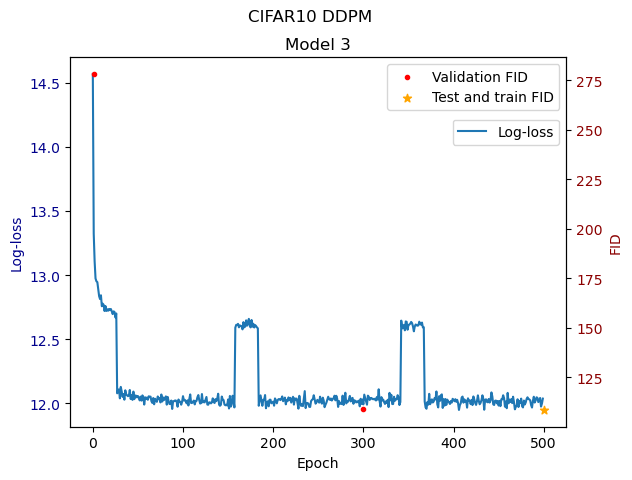

In [18]:
#valid_fid_scores = [349.9, 141.6, 150.1, 137.1, 125.4, 124.3, 121.4, 123.7, 117.3]
#test_fid_score = [107.5]
#train_fid_score = [107.8]

epochs_valid_fid = [1, 300]
epochs_loss = list(range(500))
test_fid_score = test_score
train_fid_score = train_score
fig, ax1 = plt.subplots()
plt.suptitle("CIFAR10 DDPM")
plt.title("Model 3")
ax1.plot(epochs_loss, np.log(np.array(all_epochs_loss)/64 * 16), label="Log-loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-loss', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.legend(loc="upper left", bbox_to_anchor=(0.757, 0.85))
ax2 = ax1.twinx()
ax2.scatter(epochs_valid_fid, validation_scores, color="red", marker=".", label="Validation FID")
ax2.set_ylabel('FID', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.scatter([500], test_fid_score, label="Test and train FID", marker="*", color="orange")
ax2.legend()
plt.savefig("model3.png")
plt.show()


# Overfit to one batch

In [19]:
batch_size = 16
model = UNET()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(batch_size, 1, 1, 1)
# Set the model to training mode
model.train()

for epoch in range(10000):
    x0 = single_batchs
    x0 = x0.to(device)
    t = torch.randint(1, T+1, (batch_size,)).to(device)
    #print(t.shape)
    eps = torch.randn(batch_size, 3, 32, 32).to(device)
    # print(eps.shape)
    # print(x0.shape)
    loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                torch.sqrt(1 - alpha_bar[t-1]) * eps, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32) / 1000))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

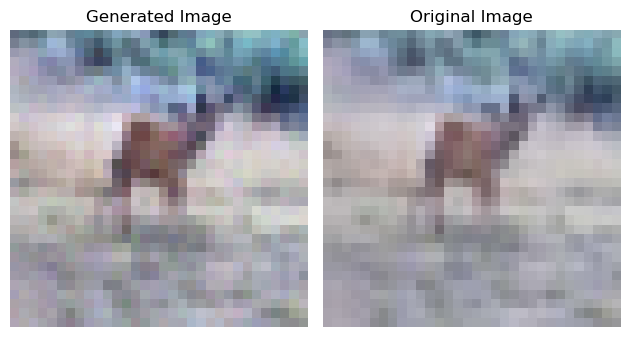

In [21]:
model.eval()
batch_size = 1
with torch.no_grad():
    xt = torch.randn(batch_size, 3, 32, 32).to(device)
    
    for t in torch.arange(T, 0, -1):
        #print(t)
        t = t.to(device)
        #print(t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32))
        z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
        xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                       model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)/1000)) + torch.sqrt(beta[t-1]) * z
        xt = xt_new
    
    # Plot the generated image
    fig,axs = plt.subplots(1, 2, tight_layout=True)
    im = xt[0].permute(1, 2, 0)
    im = im.cpu().detach().numpy()
    #print(im.max(), im.min())
    im = (im + 1) / 2 
    im = im.clip(0, 1)
    axs[0].imshow(im)
    axs[0].set_title("Generated Image")
    axs[0].axis("off")
    im_2 = single_batch[0].permute(1, 2, 0).cpu().detach().numpy()
    im_2 = (im_2 + 1)/2
    #im_2 = (im_2 - im_2.min()) / (im_2.max() - im_2.min()) 
    axs[1].imshow(im_2)
    axs[1].set_title("Original Image")
    axs[1].axis("off")
    plt.savefig("Model3Overfit")
    plt.show()